In [26]:
# Librerías
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse
from scipy import stats
from sklearn.model_selection import train_test_split
from typing import Union

In [27]:
ruta_archivo_csv = '../bases de datos/iris.csv'

# Carga los datos desde el archivo CSV en un DataFrame
datos = pd.read_csv(ruta_archivo_csv, sep=';')
display(datos.info())
datos.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


None

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


Text(0.5, 1.0, 'Gráfico de Barras de Frecuencia')

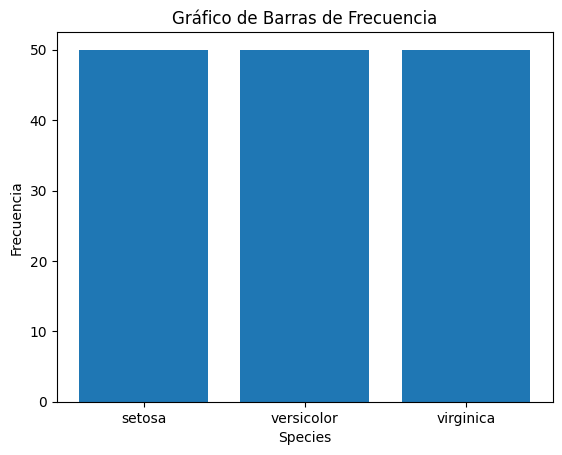

In [28]:
frecuencia = datos['Species'].value_counts()

# Crear un gráfico de barras
plt.bar(frecuencia.index, frecuencia)

# Agregar etiquetas y título
plt.xlabel('Species')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Barras de Frecuencia')

In [29]:
# Mapeo de categorías a números
mapeo = {'setosa': 1, 'versicolor': 2, 'virginica': 3}

# Aplicar el mapeo a la columna 'Categorias'
datos['Species'] = datos['Species'].map(mapeo)

Text(0.5, 1.0, 'Gráfico de Barras de Frecuencia')

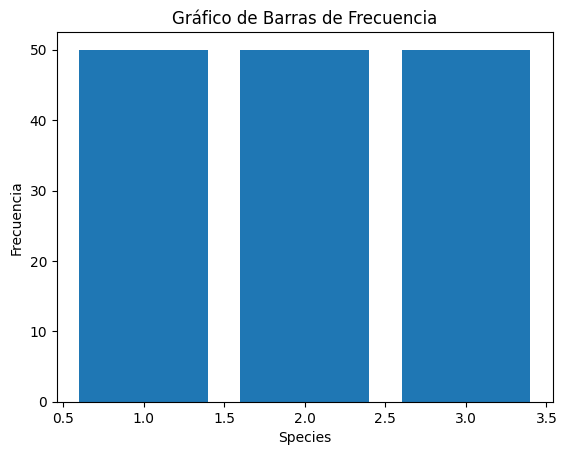

In [30]:
frecuencia = datos['Species'].value_counts()

# Crear un gráfico de barras
plt.bar(frecuencia.index, frecuencia)

# Agregar etiquetas y título
plt.xlabel('Species')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Barras de Frecuencia')

In [31]:
datos.head(3)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1


In [32]:
# División de los datos en train y test
# ==============================================================================
X = datos.drop(columns='Species')
y = datos['Species']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [33]:
# Correlación lineal entre variables numéricas
# ==============================================================================
corr_matrix = datos.corr(method='pearson')
tril = np.tril(np.ones(corr_matrix.shape)).astype(bool)
corr_matrix[tril] = np.nan
corr_matrix_tidy = corr_matrix.stack().reset_index(name='r')
corr_matrix_tidy = corr_matrix_tidy.rename(columns={'level_0': 'variable_1', 'level_1': 'variable_2'})
corr_matrix_tidy = corr_matrix_tidy.dropna()
corr_matrix_tidy['r_abs'] = corr_matrix_tidy['r'].abs()
corr_matrix_tidy = corr_matrix_tidy.sort_values('r_abs', ascending=False).reset_index(drop=True)
corr_matrix_tidy

,variable_1,variable_2,r,r_abs
0,Petal.Length,Petal.Width,0.962865,0.962865
1,Petal.Width,Species,0.956547,0.956547
2,Petal.Length,Species,0.949035,0.949035
3,Sepal.Length,Petal.Length,0.871754,0.871754
4,Sepal.Length,Petal.Width,0.817941,0.817941
5,Sepal.Length,Species,0.782561,0.782561
6,Sepal.Width,Petal.Length,-0.428440,0.428440
7,Sepal.Width,Species,-0.426658,0.426658
8,Sepal.Width,Petal.Width,-0.366126,0.366126
9,Sepal.Length,Sepal.Width,-0.117570,0.117570


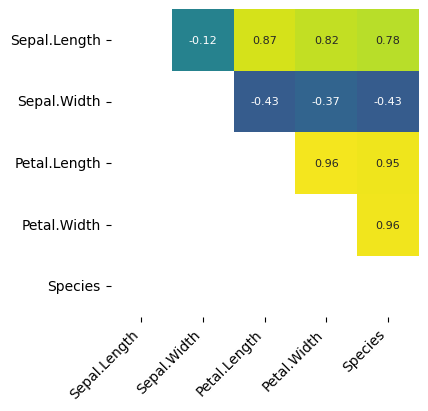

In [34]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = "viridis",
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)
ax.tick_params(labelsize = 10)


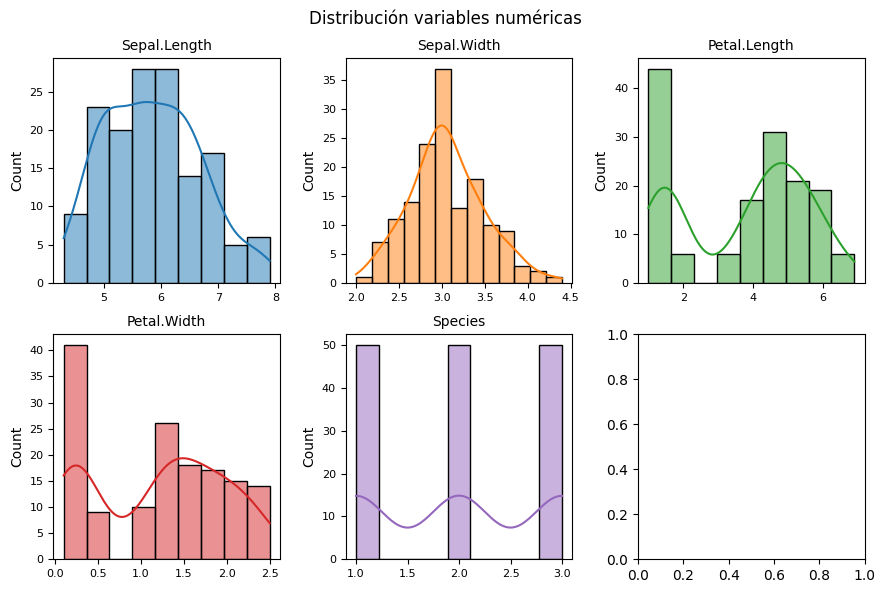

In [41]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=np.number).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10)
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")
   
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 12);

In [42]:
# Ajuste del modelo utilizando matrices X, y (similar a scikit-learn)
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s
# para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True).rename(columns={'const':'intercept'})
modelo  = sm.OLS(endog=y_train, exog=X_train)
modelo_res = modelo.fit()
print(modelo_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     382.9
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           1.87e-65
Time:                        01:50:27   Log-Likelihood:                 11.545
No. Observations:                 120   AIC:                            -13.09
Df Residuals:                     115   BIC:                            0.8467
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.2156      0.228      5.322   

In [43]:
# Funciones de selecciçon forward y backward para modelos lineales de statsmodels
# ==============================================================================

def forward_selection(
    X: pd.DataFrame,
    y: pd.Series,
    criterio: str='aic',
    add_constant: bool=True,
    verbose: bool=True
)-> list:
    
    """
    Realiza un procedimiento de selección de variables hacia adelante (forward)
    utilizando como criterio de bondad la métrica especificada. El procedimiento
    se detiene cuando no es posible mejorar más el modelo añadiendo variables.

    Parameters
    ----------
    X: pd.DataFrame
        Matriz de predictores
    y: pd.Series
        Variable respuesta
    metrica: str, default='aic'
        Métrica utilizada para seleccionar las variables. Debe ser una de las
        siguientes opciones: 'aic', 'bic', 'rsquared_adj'.
    add_constant: bool, default=True
        Si `True` añade una columna de 1s a la matriz de predictores con el
        con el nombre de intercept.
    verbose: bool, default=True
        Si `True` muestra por pantalla los resultados de cada iteración.
    
    Returns
    -------
    seleccion: list
        Lista con las variables seleccionadas.
    """

    if add_constant:
        X = sm.add_constant(X, prepend=True).rename(columns={'const':'intercept'})

    restantes = X.columns.to_list()
    seleccion = []
    if criterio == 'rsquared_adj':
        mejor_metrica = -np.inf
        ultima_metrica = -np.inf
    else:
        mejor_metrica = np.inf
        ultima_metrica = np.inf

    while restantes:
        metricas = []
        for candidata in restantes:
            seleccion_temp = seleccion + [candidata]
            modelo  = sm.OLS(endog=y, exog=X[seleccion_temp])
            modelo_res = modelo.fit()
            metrica = getattr(modelo_res, criterio)
            metricas.append(metrica)
        if criterio == 'rsquared_adj':
            mejor_metrica = max(metricas)
            if mejor_metrica > ultima_metrica:
                mejor_variable = restantes[np.argmax(metricas)]
            else:
                break
        else:
            mejor_metrica = min(metricas)
            if mejor_metrica < ultima_metrica:
                mejor_variable = restantes[np.argmin(metricas)]
            else:
                break
                
        seleccion.append(mejor_variable)
        restantes.remove(mejor_variable)
        ultima_metrica = mejor_metrica

        if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    return sorted(seleccion)


def backward_selection(
    X: pd.DataFrame,
    y: pd.Series,
    criterio: str='aic',
    add_constant: bool=True,
    verbose: bool=True
)-> list:
    
    """
    Realiza un procedimiento de selección de variables hacia atrás (backward) 
    utilizando como criterio de bondad la métrica especificada. El procedimiento
    se detiene cuando no es posible mejorar más el modelo eliminando variables.

    Parameters
    ----------
    X: pd.DataFrame
        Matriz de predictores
    y: pd.Series
        Variable respuesta
    metrica: str, default='aic'
        Métrica utilizada para seleccionar las variables. Debe ser una de las
        siguientes opciones: 'aic', 'bic', 'rsquared_adj'.
    add_constant: bool, default=True
        Si `True` añade una columna de 1s a la matriz de predictores con el
        con el nombre de intercept.
    verbose: bool, default=True
        Si `True` muestra por pantalla los resultados de cada iteración.
    
    Returns
    -------
    seleccion: list
        Lista con las variables seleccionadas.
    """

    if add_constant:
        X = sm.add_constant(X, prepend=True).rename(columns={'const':'intercept'})

    # Se inicia con todas las variables como predictores
    seleccion = X.columns.to_list()
    modelo  = sm.OLS(endog=y, exog=X[seleccion])
    modelo_res = modelo.fit()
    ultima_metrica = getattr(modelo_res, criterio)
    mejor_metrica = ultima_metrica
    if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    while seleccion:
        metricas = []
        for candidata in seleccion:
            seleccion_temp = seleccion.copy()
            seleccion_temp.remove(candidata)
            modelo  = sm.OLS(endog=y, exog=X[seleccion_temp])
            modelo_res = modelo.fit()
            metrica = getattr(modelo_res, criterio)
            metricas.append(metrica)
        if criterio == 'rsquared_adj':
            mejor_metrica = max(metricas)
            if mejor_metrica > ultima_metrica:
                peor_variable = seleccion[np.argmax(metricas)]
            else:
                break
        else:
            mejor_metrica = min(metricas)
            if mejor_metrica < ultima_metrica:
                peor_variable = seleccion[np.argmin(metricas)]
            else:
                break
                
        seleccion.remove(peor_variable)
        ultima_metrica = mejor_metrica

        if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    return sorted(seleccion)

In [44]:
# Selección de variables hacia forward
# ==============================================================================
predictores = forward_selection(
    X            = X_train,
    y            = y_train,
    criterio     = 'aic',
    add_constant = False, # Ya se le añadió anteriormente
    verbose      = True
)
predictores

variables: ['Petal.Length'] | aic: 54.940
variables: ['Petal.Length', 'intercept'] | aic: 25.981
variables: ['Petal.Length', 'intercept', 'Petal.Width'] | aic: -7.805
variables: ['Petal.Length', 'intercept', 'Petal.Width', 'Sepal.Length'] | aic: -15.086


['Petal.Length', 'Petal.Width', 'Sepal.Length', 'intercept']

In [45]:
predictores= backward_selection(
    X            = X_train,
    y            = y_train,
    criterio     = 'aic',
    add_constant = False, # Ya se le añadió anteriormente
    verbose      = True
)
predictores

variables: ['intercept', 'Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width'] | aic: -13.091
variables: ['intercept', 'Sepal.Length', 'Petal.Length', 'Petal.Width'] | aic: -15.086


['Petal.Length', 'Petal.Width', 'Sepal.Length', 'intercept']

In [46]:
# Entrenamiento del modelo con las variables seleccionadas
# ==============================================================================
modelo_final  = sm.OLS(endog=y_train, exog=X_train[predictores])
modelo_final_res = modelo_final.fit()
print(modelo_final_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     515.0
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           7.60e-67
Time:                        01:53:48   Log-Likelihood:                 11.543
No. Observations:                 120   AIC:                            -15.09
Df Residuals:                     116   BIC:                            -3.936
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Petal.Length     0.2560      0.050      5.158   

In [49]:
# Selección de predictores con sklearn SequentialFeatureSelector
# ==============================================================================
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()
sfs = SequentialFeatureSelector(
    modelo,
    n_features_to_select = 'auto',
    direction            = 'forward',
    scoring              = 'r2',
    cv                   = 5
)
sfs.fit(X_train, y_train)
sfs.get_feature_names_out().tolist()

['Petal.Length', 'Petal.Width']

In [50]:
# Residuos del modelo
# ==============================================================================
residuos = modelo_final_res.resid

# prediciones de entrenamiento
# ==============================================================================
prediccion_train = modelo_final_res.predict(X_train[predictores])

C:\Users\nala_\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


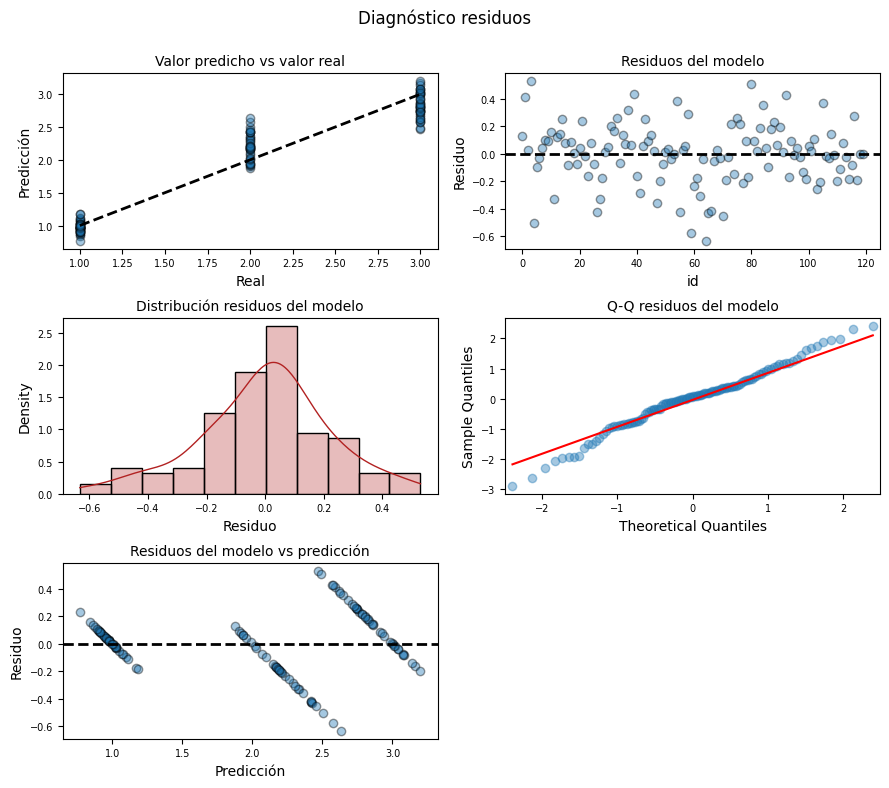

In [51]:
# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize=10)
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 1].axhline(y=0, linestyle='--', color='black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10)
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data     = residuos,
    stat     = "density",
    kde      = True,
    line_kws = {'linewidth': 1},
    color    = "firebrick",
    alpha    = 0.3,
    ax       = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize=10)
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)

sm.qqplot(
    residuos,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize=10)
axes[1, 1].tick_params(labelsize=7)

axes[2, 0].scatter(prediccion_train, residuos, edgecolors=(0, 0, 0), alpha=0.4)
axes[2, 0].axhline(y=0, linestyle='--', color='black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize=10)
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize=7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize=12);

In [52]:
# Normalidad de los residuos Shapiro-Wilk test
# ==============================================================================
shapiro_test = stats.shapiro(residuos)
print(f"Test Shapiro-Wilk: estadístico = {shapiro_test[0]}, p-value = {shapiro_test[1]}")

# Normalidad de los residuos D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(residuos)
print(f"Test D'Agostino's K-squared: estadístico = {k2}, p-value = {p_value}")

Test Shapiro-Wilk: estadístico = 0.9837618470191956, p-value = 0.1586689054965973
Test D'Agostino's K-squared: estadístico = 2.8023459792755885, p-value = 0.24630787783883917


In [53]:
# Prueba de Breusch-Pagan
# ==============================================================================
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuos, X_train[predictores])
print(f"Estadítico= {fvalue}, p-value = {f_p_value}")

Estadítico= 10.634818242342307, p-value = 3.1359098929732254e-06


In [54]:
# Correlación entre predictores numéricos
# ==============================================================================
corr_matrix = X_train[predictores].corr(method='pearson')
tril = np.tril(np.ones(corr_matrix.shape)).astype(bool)
corr_matrix[tril] = np.nan
corr_matrix_tidy = corr_matrix.stack().reset_index(name='r')
corr_matrix_tidy = corr_matrix_tidy.rename(columns={'level_0': 'variable_1', 'level_1': 'variable_2'})
corr_matrix_tidy = corr_matrix_tidy.dropna()
corr_matrix_tidy['r_abs'] = corr_matrix_tidy['r'].abs()
corr_matrix_tidy = corr_matrix_tidy.sort_values('r_abs', ascending=False).reset_index(drop=True)
corr_matrix_tidy

,variable_1,variable_2,r,r_abs
0,Petal.Length,Petal.Width,0.962114,0.962114
1,Petal.Length,Sepal.Length,0.856505,0.856505
2,Petal.Width,Sepal.Length,0.803370,0.803370


In [55]:
# Cálculo del VIF
# ==============================================================================
vif = pd.DataFrame()
vif["variables"] = X_train[predictores].columns
vif["VIF"] = [variance_inflation_factor(X_train[predictores].values, i) for i in range(X_train[predictores].shape[1])]
vif

,variables,VIF
0,Petal.Length,18.301245
1,Petal.Width,13.749290
2,Sepal.Length,3.836653
3,intercept,112.378786


In [56]:
# Prediciones del conjunto de test
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True).rename(columns={'const':'intercept'})
modelo_final_res.predict(X_test[predictores])

91     2.312280
63     2.337879
103    2.777458
6      1.060017
59     2.267775
29     1.036471
27     0.936044
35     0.889177
99     2.184367
122    2.969090
82     2.058424
42     1.004569
117    3.088648
61     2.299593
43     1.230691
79     1.851434
100    3.298309
25     0.991574
108    2.768794
94     2.224931
74     2.130806
54     2.312197
51     2.301563
73     2.218321
109    3.189218
48     0.921078
123    2.598263
92     2.084023
102    2.913869
11     1.021505
dtype: float64

In [57]:
# Predicciones con intervalo de confianza 
# ==============================================================================
# La columna mean contiene la media de la predicción
predicciones = modelo_final_res.get_prediction(exog = X_test[predictores]).summary_frame(alpha=0.05)
predicciones

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
91,2.312280,0.028487,2.255858,2.368701,1.865956,2.758604
63,2.337879,0.031967,2.274564,2.401194,1.890632,2.785127
103,2.777458,0.038370,2.701460,2.853455,2.328239,3.226676
6,1.060017,0.037463,0.985816,1.134218,0.611099,1.508935
59,2.267775,0.040416,2.187725,2.347825,1.817854,2.717697
29,1.036471,0.036945,0.963296,1.109645,0.587721,1.485220
27,0.936044,0.035379,0.865972,1.006116,0.487790,1.384298
35,0.889177,0.037522,0.814859,0.963495,0.440240,1.338114
99,2.184367,0.025920,2.133029,2.235705,1.738657,2.630076
122,2.969090,0.065129,2.840093,3.098087,2.507937,3.430243


In [58]:
# Error de test del modelo
# ==============================================================================
error = rmse(y_test.flatten(), predicciones['mean'])
print(f"El error (rmse) de test es: {error}")

El error (rmse) de test es: 0.20249742920274835
